# Dynamic programming algorithm for policy evaluation and imporvment

In [8]:
# this jupyter uses a python package created for gridworlds
# please refer to https://github.com/NadeemWard/GridWorld for more information

from gridworld.Grid import GridWorld
from gridworld.Transitions import Transitions_Probs
from gridworld.Rewards import Reward
import numpy as np
import matplotlib.pyplot as plt

def env_dynamics(transitions, rewards, actions, policy):
    '''
    Function for computing E[R_t+1 | s_t], E[R_t+1 | s_t, a_t] and P[s_t+1| s_t] following a policy 
    saved as a |S|x1, |S|x|A| and |S|x|S| list respectively
    
    :param transitions: the transition probabilities defined by the MDP ( P(s'|s,a) )
    :param rewards: the rewards defined by the environments
    :param actions: the actions defined by the env
    :param policy: the policy currently being followed
    '''

    number_states = len(policy)
    number_actions = len(actions)

    E_rewards_s = np.zeros( number_states)
    E_reward_s_a = np.zeros( (number_states, number_actions) )
    P_s_s = np.zeros( (number_states, number_states) )


    for s in range(number_states):


        for a in range(number_actions):

            p = policy[s - 1][a]

            sum_s_a = 0
            for s_prime in range(number_states):

                r = rewards[s - 1][a][s_prime - 1]
                t = transitions[s - 1][a][s_prime - 1]

                P_s_s [s-1][s_prime - 1] += p * t

                sum_s_a += r*t

            E_reward_s_a[s - 1][a] = sum_s_a
            E_rewards_s[s - 1] += sum_s_a * p

    return E_rewards_s, E_reward_s_a, P_s_s



def exact_policy_evaluation(r,P,discount):
    '''
    Function for computing the exact state values by solving the system of linear equations.
    v = r + gamma*Pv ==> v = (I - gamma*P)^-1 . r
    
    :param r: E[R_t+1 | s_t]
    :param P: P(s'|s)
    :param discount: discount parameter of MDP
    '''

    i = np.eye(len(r), len(r))
    a = (i - discount * P)

    v = np.dot(np.linalg.inv(a), r)

    return v

def iterative_policy_evaluation(r,P,discount,number_of_steps, v_initial = None):
    '''
    function for performing synchronous DP using the bellman equation.
    
    :param r: E[R_t+1 | s_t]
    :param P: P(s'|s)
    :param discount: discount parameter of MDP
    :param number_of_steps: number of steps of iterative policy evaluation you would like to make
    :param v_initial: the initial values of v (if the user wants to specify them)
    '''

    if isinstance(v_initial, (list,np.ndarray) ):
        v = v_initial
    else:
        v = np.zeros(len(r))

    counter = 0
    while(counter < number_of_steps):

        v = r + discount * ( np.dot(P,v) ) # bellman equation used as iterative update V_t+1

        counter+=1

    return v

def policy_improvement(r_s_a, P, actions, discount, v_pie):

    '''
    Function for performing policy deterministic greedy policy improvement assuming we are only working with
    state values v(s) (not q(s,a))
    
    :param r_s_a: E[R_t+1 | s_t, a_t]
    :param P: P(s'|s)
    :param discount: discount parameter of MDP
    :param actions: list of actions
    :param v_pie: the current value function values (list)
    '''
    
    number_actions = len(actions)
    new_pie = np.zeros( (len(grid.states),len(actions) )  )

    for s in grid.states:

        q_s = [] # compute all the q(s,a) for state s (i.e. q(s,a1), q(s,a2), q(s,a3), ...)
        for a in range(number_actions):
            q_s.append( r_s_a[s - 1][a] + discount * np.dot(P[s - 1][a],v_pie) )

        i = np.argmax (q_s) # find the max

        # change the policy for state s to be the max 
        for a in range(number_actions):
            if i == a:
                new_pie[s - 1][a] = 1
            else:
                new_pie[s - 1][a] = 0

    return new_pie

def modified_policy_iteration(grid,actions,initial_policy,number_of_evaluation, delta = 10 ** -6 ):

    '''
    function for doing modified policy iteration following the general policy iteration idea.
    Evaluation (specified number of times) followed by imporvement.
    
    :param grid: the grid world
    :param actions:  
    :param initial_policy: initial policy to consider
    :param number_of_evaluation: number of iterations of policy iteration to execute before imporvement
    :param delta: specified stopping critieria  
    '''
    
    policy = initial_policy
    transitions = grid.transition_probs.t_probs
    rewards = grid.reward_env.expected_rewards

    v_s = [] # a list to keep track of the value functions after each iteration of the while loop
             # not necessary for algo used for plot 

    v = np.zeros( len(grid.states) )

    while(True):

        v_old = v

        r_s, r_s_a, p = env_dynamics(transitions,rewards,actions,policy) # get transitions and rewards based
                                                                         # on current policy 
        v = iterative_policy_evaluation(r_s, p, discount, number_of_evaluation, v) #perform policy evaluation
        v_s.append(exact_policy_evaluation(r_s,p,discount))

        policy = policy_improvement(r_s_a, tp.t_probs, actions, discount, v) # improve


        if ( np.linalg.norm( (v_old - v), np.inf ) <= delta ): #stopping criteria

            break

    return v_s

def policy_iteration(grid,actions,initial_policy, delta = 10** -6):

    '''
    function for exact policy iteration. The value function is computed exactly at each iteration.
    
    :param grid: the grid world
    :param actions:  
    :param initial_policy: initial policy to consider
    :param delta: specified stopping critieria  
    '''
    
    policy = initial_policy
    transitions = grid.transition_probs.t_probs
    rewards = grid.reward_env.expected_rewards
    v_s = []
    v = np.zeros( len(grid.states) )

    
    while(True):
        v_old = v
        
        r_s,r_s_a, p = env_dynamics(transitions,rewards,actions,policy)
        v = exact_policy_evaluation(r_s,p,discount)
        v_s.append(v)

        policy = policy_improvement(r_s_a, tp.t_probs, actions, discount, v)

        if ( np.linalg.norm( (v_old - v), np.inf ) <= delta ):
            break
        
    return v_s

def get_state_value(v_s, position):
    # get the values for a specfic state over the course of all the value functions computed.

    v = []
    for v_i in v_s:
        v.append(v_i[position - 1])

    return v

In [9]:
    # Define the gridworld
    height = 5
    width = 5
    terminal_states = [1,5] 

    grid = GridWorld(height, width)
    grid.print_grid() # print function to show your grid


    # Define the environment dynamics
    actions = ["up", "down", "right", "left"]

    tp = Transitions_Probs(grid, actions)
    tp.create_common_transition(("Random",0.9))  # There are 3 choices for common transition probabilities ("Bernoulli",0.7)) # "Deterministic"
    
    defined_reward = {1:1 , 5:10} # Here, at state 1 I have a reward of 1 and at state 4 I have a reward of 10.
    reward_env = Reward(grid, actions)
    reward_env.common_reward(defined_reward)
    discount = 0.9
    
    grid.add_terminal_states(terminal_states)


    policy = np.ones((len(grid.states), len(actions))) * 0.25  # uniform policy

|1	2	3	4	5	|
|6	7	8	9	10	|
|11	12	13	14	15	|
|16	17	18	19	20	|
|21	22	23	24	25	|


### Below we consider 3 algorithms:
- value iteration
- modified value iteration where we do 3 steps of policy evaluation
- exact policy iteration where we compute the exact values of the policies at each iteration

We plot their performance as a function of how good the bottom left state's value is (the furthest state from +10 in our setup) with respect to each iteration of policy imporvement. 

In [10]:
import time

start = time.time()
v_exact = policy_iteration(grid,actions,policy)
end = time.time()

print(end - start)

0.03998899459838867


In [11]:
start = time.time()
v_val_iteration = modified_policy_iteration(grid,actions,policy,1)
end = time.time()
print(end - start)

0.09398031234741211


In [12]:
start = time.time()
v_3 = modified_policy_iteration(grid, actions, policy, 3) 
end = time.time()

print(end - start)

0.051665306091308594


number of value iterations:  6  number of modified policy iterations:  10 number of policy iteration:  24


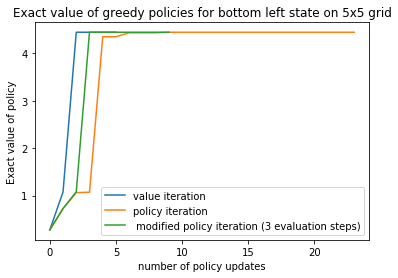

In [13]:
    bottom_left = 21
    value_iteration = get_state_value(v_exact,bottom_left)
    modif_value_iter = get_state_value(v_3,bottom_left)
    pol_iteration = get_state_value(v_val_iteration , bottom_left)

    print("number of value iterations: ",len(value_iteration), " number of modified policy iterations: ", len(modif_value_iter), "number of policy iteration: ", len(pol_iteration))

    title = "Exact value of greedy policies for bottom left state on 5x5 grid"
    plt.title(title)
    plt.plot(value_iteration[:30])
    plt.plot(pol_iteration[:30])
    plt.plot(modif_value_iter[:30])
    plt.legend(["value iteration", "policy iteration"," modified policy iteration (3 evaluation steps)"])
    plt.ylabel("Exact value of policy")
    plt.xlabel("number of policy updates")
    plt.show()